In [1]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [2]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [3]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [4]:
def bonos_dbAlgebra(n,cn):

    niu_data = pd.DataFrame()

    bonos = "SELECT TOP ("+ str(n) +") Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, NemotecnicoBono AS Nemotecnico, RiesgoInt FROM (SELECT * FROM (SELECT Moneda, Base1  , Base2, TablaDesarrollo , FechaEmision, Nemotecnico AS NemotecnicoBono FROM [dbAlgebra].[dbo].[TdNemoRF]) AS bono JOIN (SELECT * FROM [dbPortFolio].[dbo].[TdPlanvitalCartera]) AS planvital ON bono.FechaEmision > '20190101' AND bono.NemotecnicoBono = planvital.Nemotecnico) AS A JOIN (SELECT DISTINCT Nemotecnico, RiesgoLVA AS RiesgoInt FROM [dbAlgebra].[dbo].[TdRiesgoLva]) AS B ON A.NemotecnicoBono = B.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)

    moneda = []
    base1 = []
    base2 = []
    tabla = []
    fechaemi = []
    nemotecnico = []
    riesgo = []
    for i in range(np.size(bonos, 0)):

        if bonos["Nemotecnico"][i] in nemotecnico: continue

        if bonos["RiesgoInt"][i] in riesgo : continue

        moneda.append(bonos["Moneda"][i])
        base1.append(bonos["Base1"][i])
        base2.append(bonos["Base2"][i])
        tabla.append(bonos["TablaDesarrollo"][i])
        fechaemi.append(bonos["FechaEmision"][i])
        nemotecnico.append(bonos["Nemotecnico"][i])
        riesgo.append(bonos["RiesgoInt"][i])

    niu_data["Moneda"] = moneda
    niu_data["Base1"] = base1
    niu_data["Base2"] = base2
    niu_data["TablaDesarrollo"] = tabla
    niu_data["FechaEmision"] = fechaemi
    niu_data["Nemotecnico"] = nemotecnico
    niu_data["RiesgoInt"] = riesgo


    return niu_data

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = 'BCINO UF 200709_A'
    return derivado

In [5]:
def conversionSYP(riesgo):
    return {-1: "AAA", 1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
bonos = ajustes(bonos_dbAlgebra(500,cn))
bonos

,Moneda,Base1,Base2,TablaDesarrollo,FechaEmision,Nemotecnico,RiesgoInt,Convencion,Riesgo
0,UF,ACT,365,"1#01-10-2019#0,35#0#100#0,35|2#01-04-2020#0,35...",2019-04-01,BSECB90419,3,ACT/365,AA
1,UF,ACT,365,"1#30-04-2019#0,48208#8,1616#91,8384#8,64368|2#...",2019-01-31,BSXXI-A,1,ACT/365,AAA
2,UF,ACT,365,"1#30-10-2019#1,094#0#100#1,094|2#30-04-2020#1,...",2019-04-30,BVIAS-A,4,ACT/365,AA
3,UF,ACT,365,"1#01-03-2020#0,3245#0#100#0,3245|2#01-09-2020#...",2019-09-01,BCSSA-C,2,ACT/365,AA
4,UF,ACT,365,"1#15-10-2019#1,7841#0#100#1,7841|2#15-04-2020#...",2019-04-15,BLATM-E,8,ACT/365,BBB
5,UF,ACT,365,"1#01-12-2019#0,8464#0#100#0,8464|2#01-06-2020#...",2019-06-01,BCMPC-O,-1,ACT/365,AAA


In [7]:
bonos["Riesgo"].values

array(['AA', 'AAA', 'AA', 'AA', 'BBB', 'AAA'], dtype=object)

In [8]:
derivados = derivados_dBDerivados(2, cn)
derivados["Derivado"][0].genera_flujos()
derivados["Derivado"][0].valoriza_flujos()
derivados["Derivado"][0].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1368,-1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,4.331011e+07,4.293818e+07,CLP,CLP
1,1368,-1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.549401e+07,3.494116e+07,CLP,CLP
2,1368,-1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,4.784481e+07,4.665317e+07,CLP,CLP
3,1368,-1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.042244e+09,4.875468e+09,CLP,CLP
4,1368,1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,3.652233e+07,3.620869e+07,CLP,CLP
5,1368,1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.692515e+07,3.635001e+07,CLP,CLP
6,1368,1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,3.632093e+07,3.541630e+07,CLP,CLP
7,1368,1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.036925e+09,4.870324e+09,CLP,CLP


In [9]:
arreglo_acciones = ["AESGENER", "AGUAS-A", "ANDINA-A", "ANDINA-B", "DE000DWS2D90", "ANTARCHILE"]
arreglo_fondos = ["A", "A", "A", "A", "A", "A"]


acciones = historico(arreglo_acciones, arreglo_fondos, 60)
acciones


,Moneda,Nombre,Nemotecnico,Inversion,Historico
0,CLP,AESGENER,AESGENER,1.711040e+09,"[[0, 0.0025957870479299534, -0.007433469137058..."
1,CLP,AGUAS-A,AGUAS-A,1.531281e+07,"[[0, 0.003305297208302039, 0.03566773260328181..."
2,CLP,ANDINA-A,ANDINA-A,1.492768e+08,"[[0, 0.00034804011961498776, 0.018505998119275..."
3,CLP,ANDINA-B,ANDINA-B,1.073699e+09,"[[0, 0.005746838657845234, 0.0175731917247771,..."
4,CLP,DE000DWS2D90,DE000DWS2D90,1.194112e+10,"[[0, -0.011984448831005957, -0.025391621016988..."
5,CLP,ANTARCHILE,ANTARCHILE,1.511532e+08,"[[0, 0.009876696995043567, 0.00310408270978682..."


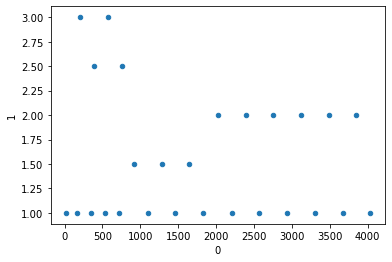

In [10]:
cartera = Cartera(acciones, bonos.head(3), derivados, "CLP", datetime.date(2019, 10, 14), cn)

In [13]:
cartera.get_diccionario_niveles()

{1: {('Renta Variable Nacional Acciones',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 1.51153165e+08]),
  ('Renta Variable Extranjera',
   'Accion'): array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.19411228e+10, 0.00000000e+00]),
  ('Renta Fija Nacional',
   'Bono',
   'AA'): array([0.00000000e+00, 9.50679768e-03, 2.35642003e-01, 1.73726278e-02,
         1.40680733e-01, 1.75118499e-02, 7.86186036e-02, 1.36304231e-02,
         7.38935820e-02, 1.83978719e-02, 7.87546766e-05, 5.10714339e-05,
         5.12239445e-03, 2.04353588e-03, 5.97025198e-03, 1.04498840e-01,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
  ('Renta Fija Nacional ',
   'Bono',
   'AAA'): array([0.        , 8.44542292, 1.16356666, 0.        , 0.        ,
         0. 

In [11]:
print(cartera.get_bonos()[0].get_historicos())

UF#16#AA  UF#168#AA  UF#203#AA  UF#349#AA  UF#384#AA  UF#528#AA  \
0   1.002429   1.025797   1.031255   1.054336   1.059939   1.083274   
1   1.002409   1.025589   1.031002   1.053891   1.059453   1.082648   
2   1.002379   1.025268   1.030612   1.053206   1.058698   1.081610   
3   1.002411   1.025607   1.031023   1.053929   1.059496   1.082708   
4   1.002412   1.025623   1.031043   1.053963   1.059533   1.082761   
5   0.999553   0.994187   0.992627   0.984451   0.982037   0.969843   
6   0.999542   0.992577   0.990106   0.974340   0.970930   0.960274   
7   0.999543   0.992761   0.990400   0.975621   0.972413   0.962213   
8   0.999557   0.994689   0.993386   0.987087   0.985354   0.977187   
9   0.999555   0.994404   0.992957   0.985620   0.983516   0.973181   
10  0.999558   0.994780   0.993522   0.987537   0.985914   0.978373   
11  0.999556   0.994502   0.993105   0.986133   0.984160   0.974604   
12  0.999548   0.993399   0.991408   0.979814   0.977290   0.968922   
13  0.9995

In [12]:
print(cartera.get_retornos_totales())

CLP#16#AA  CLP#168#AA  CLP#203#AA  CLP#349#AA  CLP#384#AA  CLP#528#AA  \
0   0.000000e+00    0.000000    0.000000    0.000000    0.000000    0.000000   
1   7.723773e-05   -0.000107   -0.000149   -0.000326   -0.000362   -0.000481   
2   6.678852e-05   -0.000216   -0.000282   -0.000554   -0.000616   -0.000863   
3   3.215956e-04    0.000621    0.000690    0.000977    0.001043    0.001305   
4   9.804650e-05    0.000112    0.000115    0.000129    0.000132    0.000145   
5  -2.759734e-03   -0.031033   -0.037874   -0.068132   -0.075858   -0.110038   
6   8.549467e-05   -0.001524   -0.002446   -0.010227   -0.011279   -0.009820   
7   9.804600e-05    0.000282    0.000394    0.001411    0.001623    0.002114   
8   3.038273e-04    0.002230    0.003300    0.011974    0.013511    0.015733   
9   9.418559e-05   -0.000190   -0.000336   -0.001391   -0.001771   -0.004011   
10  9.956529e-05    0.000474    0.000665    0.002040    0.002532    0.005417   
11  9.490971e-05   -0.000182   -0.000323   -0.0

In [14]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

0.0038300564379370756


In [15]:
cartera.get_covarianza()

,CLP#16#AA,CLP#168#AA,CLP#203#AA,CLP#349#AA,CLP#384#AA,CLP#528#AA,CLP#563#AA,CLP#709#AA,CLP#744#AA,CLP#902#AA,...,CLP#3439,CLP#3619,CLP#3799,CLP#3979,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#16#AA,1.588549e-07,0.000002,0.000002,0.000004,0.000005,0.000006,0.000007,0.000008,0.000009,0.000009,...,3.392284e-09,4.704998e-08,4.820711e-08,3.821852e-08,6.864342e-07,-0.000001,0.000001,2.428227e-07,-6.093258e-07,-6.363597e-07
CLP#168#AA,1.658468e-06,0.000020,0.000025,0.000050,0.000056,0.000076,0.000081,0.000100,0.000102,0.000107,...,-7.423479e-07,-4.005299e-07,-4.462853e-07,-5.910690e-07,8.606507e-06,-0.000014,0.000016,1.144554e-05,-7.560963e-06,-9.027885e-06
CLP#203#AA,2.059064e-06,0.000025,0.000031,0.000063,0.000071,0.000095,0.000101,0.000124,0.000127,0.000132,...,-9.781869e-07,-5.552559e-07,-6.143189e-07,-7.967519e-07,1.039511e-05,-0.000017,0.000020,1.466988e-05,-9.243972e-06,-1.149979e-05
CLP#349#AA,4.078488e-06,0.000050,0.000063,0.000134,0.000150,0.000197,0.000208,0.000248,0.000253,0.000259,...,-2.377887e-06,-1.537334e-06,-1.667817e-06,-2.049517e-06,1.728140e-05,-0.000033,0.000042,3.235730e-05,-1.661364e-05,-2.525471e-05
CLP#384#AA,4.543476e-06,0.000056,0.000071,0.000150,0.000166,0.000220,0.000232,0.000277,0.000283,0.000289,...,-2.604370e-06,-1.668147e-06,-1.812418e-06,-2.235985e-06,1.947482e-05,-0.000037,0.000047,3.592180e-05,-1.863772e-05,-2.806489e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGUAS-A,-1.211563e-06,-0.000014,-0.000017,-0.000033,-0.000037,-0.000052,-0.000056,-0.000072,-0.000074,-0.000079,...,-5.113812e-06,-6.008652e-06,-6.323831e-06,-6.493404e-06,-1.186742e-05,0.000100,0.000039,5.782428e-05,1.555668e-05,3.732992e-05
ANDINA-A,1.291345e-06,0.000016,0.000020,0.000042,0.000047,0.000064,0.000067,0.000083,0.000085,0.000086,...,2.235978e-05,2.458988e-05,2.521700e-05,2.545841e-05,1.549880e-05,0.000039,0.000418,8.402807e-05,5.061778e-05,8.513652e-05
ANDINA-B,2.428227e-07,0.000011,0.000015,0.000032,0.000036,0.000046,0.000048,0.000053,0.000052,0.000039,...,-1.630319e-05,-1.697804e-05,-1.809624e-05,-1.931872e-05,-2.912010e-06,0.000058,0.000084,4.329248e-04,8.275641e-06,8.386062e-05
DE000DWS2D90,-6.093258e-07,-0.000008,-0.000009,-0.000017,-0.000019,-0.000028,-0.000031,-0.000044,-0.000045,-0.000046,...,1.006899e-05,9.952890e-06,1.044678e-05,1.108377e-05,-6.436894e-06,0.000016,0.000051,8.275641e-06,6.330338e-05,9.187219e-06


In [16]:
cartera.get_correlacion()

,CLP#16#AA,CLP#168#AA,CLP#203#AA,CLP#349#AA,CLP#384#AA,CLP#528#AA,CLP#563#AA,CLP#709#AA,CLP#744#AA,CLP#902#AA,...,CLP#3439,CLP#3619,CLP#3799,CLP#3979,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#16#AA,1.000000,0.936402,0.928911,0.882812,0.883780,0.914220,0.920124,0.932550,0.932030,0.914676,...,0.001743,0.022995,0.022536,0.017141,0.128069,-0.304073,0.158499,0.029281,-0.192148,-0.129608
CLP#168#AA,0.936402,1.000000,0.999269,0.977388,0.978213,0.995142,0.996972,0.988176,0.984674,0.957570,...,-0.034214,-0.017558,-0.018713,-0.023777,0.144021,-0.304412,0.171851,0.123790,-0.213855,-0.164919
CLP#203#AA,0.928911,0.999269,1.000000,0.984728,0.985405,0.997781,0.998339,0.983384,0.979016,0.949215,...,-0.036022,-0.019448,-0.020581,-0.025609,0.138988,-0.302544,0.173403,0.126772,-0.208905,-0.167851
CLP#349#AA,0.882812,0.977388,0.984728,1.000000,0.999976,0.991124,0.985807,0.942740,0.934427,0.892496,...,-0.042015,-0.025836,-0.026809,-0.031608,0.110865,-0.288467,0.177725,0.134164,-0.180144,-0.176864
CLP#384#AA,0.883780,0.978213,0.985405,0.999976,1.000000,0.991856,0.986733,0.944585,0.936377,0.894657,...,-0.041352,-0.025193,-0.026181,-0.030988,0.112273,-0.289312,0.178476,0.133847,-0.181608,-0.176623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AGUAS-A,-0.304073,-0.304412,-0.302544,-0.288467,-0.289312,-0.302907,-0.305861,-0.314929,-0.315757,-0.314005,...,-0.104765,-0.117082,-0.117863,-0.116111,-0.088274,1.000000,0.188988,0.277994,0.195585,0.303122
ANDINA-A,0.158499,0.171851,0.173403,0.177725,0.178476,0.181023,0.181185,0.178639,0.177379,0.168400,...,0.224024,0.234328,0.229850,0.222631,0.056380,0.188988,1.000000,0.197562,0.311225,0.338087
ANDINA-B,0.029281,0.123790,0.126772,0.134164,0.133847,0.127803,0.125665,0.112854,0.107476,0.073960,...,-0.160475,-0.158951,-0.162050,-0.165975,-0.010407,0.277994,0.197562,1.000000,0.049990,0.327175
DE000DWS2D90,-0.192148,-0.213855,-0.208905,-0.180144,-0.181608,-0.207684,-0.214345,-0.242849,-0.243877,-0.231909,...,0.259188,0.243679,0.244645,0.249026,-0.060160,0.195585,0.311225,0.049990,1.000000,0.093734


In [17]:
cartera.get_volatilidad_niveles()

{1: {('Renta Variable Nacional Acciones', 'Accion'): 0.012318889593453,
  ('Renta Variable Extranjera', 'Accion'): 0.00795634184685601,
  ('Renta Fija Nacional', 'Bono', 'AA'): 0.007017709219997556,
  ('Renta Fija Nacional ', 'Bono', 'AAA'): 0.026916519897491664,
  ('Renta Fija Nacional ', 'Bono', 'AA'): 0.00767507700039575,
  ('Derivados', 'Derivado'): 0.0001196137590951696},
 2: {('Acciones Electricas', 'Accion'): 0.013447928815144039,
  ('Acciones Servicios', 'Accion'): 0.00999697675731327,
  ('Acciones Industrial', 'Accion'): 0.02080684545966357,
  ('Equities Europe', 'Accion'): 0.00795634184685601,
  ('Acciones Recursos Naturales', 'Accion'): 0.012318889593453,
  ('Bonos Financieros', 'Bono', 'AA'): 0.00842695197455307,
  ('Bonos Corporativos', 'Bono', 'AAA'): 0.02689244234498333,
  ('Bonos Corporativos', 'Bono', 'AA'): 0.007672717495193712,
  ('Derivados FWD Inversión', 'Derivado'): 0.0001196137590951865}}

In [20]:
cartera.manito_de_dioh()

['CLPAA', 'CLPAAA']

In [ ]:
cartera.var_i_porcentual_dinero(cartera.get_monto())